In [1]:
!pip install -q accelerate torch
!pip install -U scikit-learn
!pip install umap-learn
!pip install tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Import basic computation libraries along with data visualization and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
import umap
import umap.plot
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'iframe'

# Import our data class which will organize MNIST and provide anchor, positive and negative samples.
from mnist_dataset import MNISTDataset

In [7]:
# Load data from csv
data = pd.read_csv('digit-recognizer/train.csv')
val_count = 1000
# common transformation for both val and train
default_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# Split data into val and train
dataset = MNISTDataset(data.iloc[:-val_count], default_transform)
val_dataset = MNISTDataset(data.iloc[-val_count:], default_transform)

100%|██████████| 1000/1000 [00:01<00:00, 627.85it/s]


In [8]:
# SETUP DATALOADERS
trainLoader = DataLoader(
    dataset,
    batch_size=16, # feel free to modify this value
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    prefetch_factor=100
)

valLoader = DataLoader(val_dataset,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    prefetch_factor=100
)

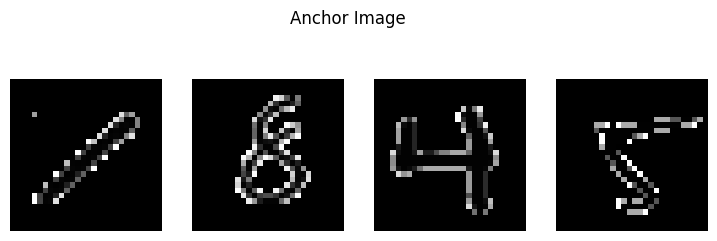

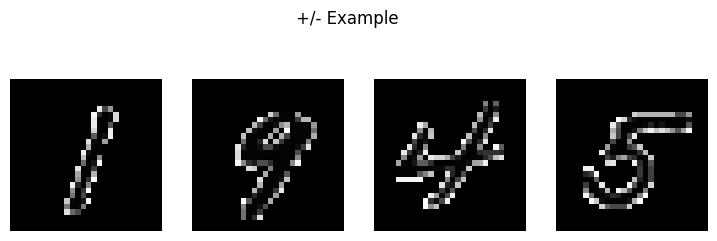

In [9]:
def show_images(images, title=''):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(9, 3))
    for i in range(num_images):
        img = np.squeeze(images[i])
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()

# Visualize some examples
for batch_idx, (anchor_images, contrastive_images, distances, labels) in enumerate(trainLoader):
    # Convert tensors to numpy arrays
    anchor_images = anchor_images.numpy()
    contrastive_images = contrastive_images.numpy()
    labels = labels.numpy()
    
    # Display some samples from the batch
    show_images(anchor_images[:4], title='Anchor Image')
    show_images(contrastive_images[:4], title='+/- Example')
    
    # Break after displaying one batch for demonstration
    break


In [11]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Dropout(0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Dropout(0.3)
        )
        self.linear1 = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 64),
        )

    def forward(self, x):
        x = self.conv1(x) # x: d * 32 * 12 * 12
        x = self.conv2(x) # x: d * 64 * 4  * 4 
        x = x.view(x.size(0), -1) # x: d * (64*4*4)
        x = self.linear1(x) # x: d * 64
        return x

In [12]:
# The ideal distance metric for a positive sample is set to 1, for a negative sample it is set to 0      
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.similarity = nn.CosineSimilarity(dim=-1, eps=1e-7)

    def forward(self, anchor, contrastive, distance):
        # use cosine similarity from torch to get score
        score = self.similarity(anchor, contrastive)
        # after cosine apply MSE between distance and score
        return nn.MSELoss()(score, distance) #Ensures that the calculated score is close to the ideal distance (1 or 0)

In [13]:
net = Network()

device = 'cuda'
if torch.cuda.is_available():
    device = torch.device(device=device)
    
net = net.to(device)
device

device(type='cuda')

In [14]:
# Define the training configuration
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_function = ContrastiveLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.3)

In [44]:
import os

# Define a directory to save the checkpoints
checkpoint_dir = 'checkpoints/'

# Ensure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [47]:
def train_model(epoch_count=10):#
    net = Network()
    lrs = []
    losses = []

    for epoch in range(epoch_count):
        epoch_loss = 0
        batches=0
        print('epoch -', epoch)
        lrs.append(optimizer.param_groups[0]['lr'])
        print('learning rate', lrs[-1])
    
        for anchor, contrastive, distance, label in tqdm(trainLoader):
            batches += 1
            optimizer.zero_grad()
            anchor_out = net(anchor.to(device))
            contrastive_out = net(contrastive.to(device))
            distance = distance.to(torch.float32).to(device)
            loss = loss_function(anchor_out, contrastive_out, distance)
            epoch_loss += loss
            loss.backward()
            optimizer.step()

        losses.append(epoch_loss.cpu().detach().numpy() / batches)
        scheduler.step()
        print('epoch_loss', losses[-1])
    
        # Save a checkpoint of the model
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
        torch.save(net.state_dict(), checkpoint_path)

    return {
        "net": net,
        "losses": losses
    }

In [48]:

train_model()

epoch - 0
learning rate 0.005


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [33]:
def load_model_from_checkpoint():
    
    checkpoint = torch.load('checkpoints/')
    
    net = Network()
    net.load_state_dict(checkpoint)

    net.eval()

    return net

In [34]:
train = False # set to True to run train the model

if train:
    training_result = train_model()
    model = training_result["net"]
else:
    model = load_model_from_checkpoint()

PermissionError: [Errno 13] Permission denied: 'checkpoints/'